In [1]:
import pandas as pd
import numpy as np
import string, html
import langid

from time import time
from pathlib import Path
from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
#from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

SELECT_YEAR = 2017

DATA_PATH = './data'
PAPERS_FILE = '{}/papers_22072019.csv.xz'.format(DATA_PATH)
WORKS_FILE  = '{}/works_22072019.csv.xz'.format(DATA_PATH)

DEFAULT_STEMMER = SnowballStemmer('english')
DEFAULT_STOPWORDS = stopwords.words('english')

### Data Read

In [2]:
# Artigos Extraidos
df_papers = pd.read_csv(PAPERS_FILE, sep='|', compression='xz')
df_papers.drop(df_papers.loc[df_papers['idioma']!='Inglês'].index, inplace=True)
df_papers.drop(['id_doc','autores_cnpq','autores','idioma','revista','natureza'], axis=1, inplace=True)
df_papers.dropna(inplace=True)
df_papers.reset_index(inplace=True, drop=True)

# Trabalhos Extraidos
df_works = pd.read_csv(WORKS_FILE, sep='|', compression='xz')
df_works.drop(df_works.loc[df_works['idioma']!='Inglês'].index, inplace=True)
df_works.drop(['id_doc','autores_cnpq','autores','idioma','anais','natureza'], axis=1, inplace=True)
df_works.dropna(inplace=True)
df_works.reset_index(inplace=True, drop=True)

print('{} artigos\n{} trabalhos'.format(df_papers.shape, df_works.shape))

(61154, 3) artigos
(119965, 3) trabalhos


### Concatena Dataframes

In [3]:
frames = [df_papers, df_works]
df = pd.concat(frames)
del [frames, df_papers, df_works]

df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.sort_values(by=['id','ano'], ignore_index=True, inplace=True)

# Localiza dados invalidos para 'ano' / Converte 'ano' em int
df.drop(df.loc[~df['ano'].astype(str).str.isnumeric()].index, inplace=True)
df['ano'] = df['ano'].astype(int)

print('{} docs shape [concat]'.format(df.shape))
df.dtypes

(180252, 3) docs shape [concat]


id         int64
titulo    object
ano        int64
dtype: object

### Seleciona Ano/Concacatena Autor

(3055, 2) docs shape [SELECT_YEAR]


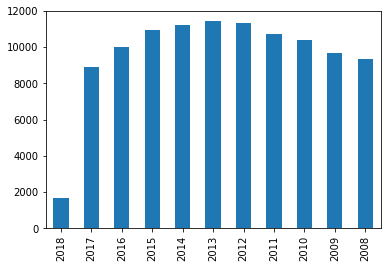

In [4]:
df['ano'].value_counts().sort_index(ascending=False).head(11).plot(kind='bar')

df.drop(df.loc[df['ano']!=SELECT_YEAR].index, inplace=True)
df.sort_values(by=['id'], ignore_index=True, inplace=True)

# Concatena por Autor
df.drop(['ano'], axis=1, inplace=True)
df = df.groupby('id', sort=False).titulo.apply(' '.join).reset_index(name='titulo')

print('{} docs shape [SELECT_YEAR]'.format(df.shape))

### Normalização

In [5]:
df.insert(2, 'clean', df['titulo'])

def decode_html(doc):
    decoded = html.unescape(doc)
    return decoded

def strip_html(doc):
    soup = BeautifulSoup(doc, "html.parser")
    return soup.get_text()

def remove_separation(doc):
    table = doc.maketrans('-/', '  ')
    return doc.translate(table)

def strip_ponct(doc):
    table = str.maketrans({key: None for key in string.punctuation})
    return doc.translate(table)

def normaliza(doc):
    doc = decode_html(doc)
    doc = strip_html(doc)
    doc = remove_separation(doc)
    doc = strip_ponct(doc)
    doc = doc.lower()
    return doc

t = time()
df['clean'] = df['clean'].apply(normaliza)
print('Normalization Time: {} mins'.format(round((time() - t) / 60, 2)))
df

Normalization Time: 0.01 mins


,id,titulo,clean
0,104124422364023,Exploiting photo location and direction for cl...,exploiting photo location and direction for cl...
1,105670521813027,Gene expression analysis in <i>Musa acuminata<...,gene expression analysis in musa acuminata dur...
2,109837868064895,A study of equivalent electrical circuit fitti...,a study of equivalent electrical circuit fitti...
3,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,dynamics of connected vessels with runaway rea...
4,117460865270656,YBS heuristic for routing and spectrum allocat...,ybs heuristic for routing and spectrum allocat...
...,...,...,...
3050,9976045320641172,Retrieving 2D shapes by similarity based on ba...,retrieving 2d shapes by similarity based on ba...
3051,9981634193003068,Spatiotemporal Data Representation in R PostGI...,spatiotemporal data representation in r postgi...
3052,9990463602315076,An Interactive Tool for the Synthesis of Conso...,an interactive tool for the synthesis of conso...
3053,9997398594109675,A sentence a day: how to engage students in a ...,a sentence a day how to engage students in a d...


### Detect language (experimental)

In [6]:
def detect_language(doc):
    lang, log_prob = langid.classify(doc)
    if lang != 'en':
        return np.nan
    return doc

df['clean'] = df['clean'].apply(detect_language)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
print('{} docs shape [concat]'.format(df.shape))

(2984, 3) docs shape [concat]


### Stopwords / Lemma

In [7]:
def remove_stopwords(doc, stop_words=DEFAULT_STOPWORDS):
    words = [w for w in doc if not w in stop_words]
    return words

def stem_text(doc, stemmer=DEFAULT_STEMMER):
    words = [stemmer.stem(w) for w in doc]
    return words

def preprocess(doc):
    doc = word_tokenize(doc)
    doc = remove_stopwords(doc)
    doc = stem_text(doc)
    doc = [w for w in doc if len(w) > 1]
    return doc

t = time()
df['clean'] = df['clean'].apply(preprocess)
print('Pre Procces Time: {} mins'.format(round((time() - t) / 60, 2)))
df.head(10)

Pre Procces Time: 0.05 mins


,id,titulo,clean
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,..."
1,105670521813027,Gene expression analysis in <i>Musa acuminata<...,"[gene, express, analysi, musa, acuminata, comp..."
2,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro..."
3,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri..."
4,117460865270656,YBS heuristic for routing and spectrum allocat...,"[ybs, heurist, rout, spectrum, alloc, flexibl,..."
5,120615995402345,Efficient and Modular Consensus-Free Reconfigu...,"[effici, modular, consensus, free, reconfigur,..."
6,122307432250869,Quaternion-based Deep Belief Networks Fine-Tun...,"[quaternion, base, deep, belief, network, fine..."
7,122321907341579,A Brazilian look at occupational health and sa...,"[brazilian, look, occup, health, safeti, usa, ..."
8,122916218414168,IoT Applied To Precision LABCONM: A Remote Lab...,"[iot, appli, precis, labconm, remot, lab, lear..."
9,125036186628507,Self-Adaptive Role-Based Access Control for Bu...,"[self, adapt, role, base, access, control, bus..."


### Remove Noise

In [8]:
noise_file = open('{}/extra/noise.txt'.format(DATA_PATH),'r')
noise = noise_file.read().splitlines()

def remove_noise(doc):
    words = [w for w in doc if not w in noise]
    return words

t = time()
df['clean'] = df['clean'].apply(remove_noise)

# Destokenizar
df['clean'] = df['clean'].apply(lambda x: ' '.join(x))

print('Remove Noise Time: {} mins'.format(round((time() - t) / 60, 2)))

Remove Noise Time: 0.0 mins


### Salva CSV

In [9]:
path = '{}/'.format(DATA_PATH)
Path(path).mkdir(exist_ok=True)

pre_file = '{}/{}lattesPre.txt'.format(DATA_PATH, SELECT_YEAR)
ida_file = '{}/{}authors.csv.xz'.format(DATA_PATH, SELECT_YEAR)

df.to_csv(ida_file, index=None, header=False, compression='xz', columns=['id'])
df.to_csv(pre_file, index=None, header=False, columns=['clean'])